# Introduction

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

**Features**:<br>
Survived - Whether the passenger survived (1) or not (0).<br>
Pclass - Ticket class. A proxy for socio-economic status (SES), i.e. 1st = Upper, 2nd = Middle, 3rd = Lower.<br>
Name - Passenger name.<br>
Sex - Passenger sex.<br>
Age - Passenger age in years.<br>
SibSp - Number of siblings / spouses aboard the Titanic.<br>
Parch - Number of parents / children aboard the Titanic.<br>
Ticket - Ticket number.<br>
Fare - Passenger fare.<br>
Cabin - Cabin number.<br>
Embarked - Port of Embarkation, i.e. C = Cherbourg, Q = Queenstown, S = Southampton.<br>

**This Notebook Covers:**
1. Exploratory Data Analysis
1. Building custom transformers and preprocessing pipeline.
1. Comparison of different models' baseline scores.
1. Choosing the best model and tuning it.
1. Final submission.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import math
import imgaug.augmenters as iaa
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, cross_val_predict, learning_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, make_scorer,roc_curve, precision_recall_curve
from sklearn.utils.validation import check_is_fitted
from sklearn import set_config
from scipy.stats import expon, randint, geom, reciprocal
from scipy.ndimage.interpolation import shift
from IPython.display import Markdown, display
from matplotlib.colors import ListedColormap

pd.set_option('display.max_columns', None)

# to make this notebook's output stable across runs
np.random.seed(42)

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")
        
# MODELS_PATH = Path("models")
# MODELS_PATH.mkdir(exist_ok=True) 

# =============================================================================
# This patch comes from.
# https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Parameter, Signature, signature

    import pandas as pd
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        # print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(KNNImputer, "get_feature_names_out"):
        # print("Monkey-patching KNNImputer.get_feature_names_out()")
        KNNImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        # print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


if ON_KAGGLE:
    monkey_patch_get_signature_names_out()

### Data Collection

In [2]:
competition = "titanic"
if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    
train_data = pd.read_csv(train_path, index_col="PassengerId")
test_data = pd.read_csv(test_path, index_col="PassengerId")

In [3]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
submission_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Analysis

Explore the dataset, analyze distributions, and visualize relationships.

In [6]:
print(f'Train data shape:\t {train_data.shape}',
    f'\nTest data shape:\t {test_data.shape}')

Train data shape:	 (891, 11) 
Test data shape:	 (418, 10)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


We see that the dataset is relatively small, with only 891 entries. There are missing values in the dataset.

In [9]:
print('Train dataset, missing values:\n', train_data.isna().sum())

Train dataset, missing values:
 Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [10]:
train_data.loc[:, train_data.columns != 'PassengerId'].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Create a copy of the training set for further analysys.

In [11]:
train_data_eda = train_data.copy()

The format of the Cabin field values contains one letter and a number. Extract the first letter from the field and place it in a separate field CabinCat. For empty values create a separate category "X".

In [12]:
train_data_eda['CabinCat'] = train_data_eda["Cabin"].apply(lambda x: "X" if pd.isna(x) else x[0])
train_data_eda['CabinCat'].value_counts()

X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinCat, dtype: int64

There are repeated values in the Name field, they are titles. Let's extract them into a separate attribute "Title".

In [13]:
train_data_eda['Title'] = train_data_eda.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_data_eda['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [14]:
train_data_eda.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCat,Title
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs


Let's analyze the attribute distributions and the survival rate.

In [15]:
def categorical_analysis(df, column_name, rate_column = 'Survived'):
    total_count = df[column_name].count()
    groupby_col = df.groupby(column_name).agg({column_name: 'count'})
    groupby_col.columns = ['count']
    groupby_col['percentage'] = groupby_col['count'] / total_count * 100
    if column_name != rate_column:
        survived_rate = df[[column_name, rate_column]].groupby([column_name]).mean()[[rate_column]]
        merged_df = pd.merge(groupby_col, survived_rate, left_index=True, right_index=True)
    else:
        merged_df = groupby_col
    display(merged_df
            .style.format({'percentage': '{:.2f}%'})
            .set_properties(**{'text-align': 'center'})
            .set_table_attributes("style='display:inline'"))

In [16]:
def find_categorical_columns(df, threshold=0.1):
    categorical_cols = []
    for col in df.columns:
        if df[col].nunique() / df[col].count() < threshold:
            categorical_cols.append(col)
    return categorical_cols

In [17]:
def plot_count_and_rate(df, col1, col2, axes, hide_labels=True):
    total = len(df)*1.
    sns.barplot(data=df, x=col1, y=col2, ax=axes[0])
    axes[0].bar_label(axes[0].containers[0], fmt='%.2f')
    axes[0].set_title(col1)
    axes[0].set_ylabel(f"{col2} rate")
    if hide_labels:
        axes[0].get_yaxis().set_visible(False)
    axes[0].xaxis.label.set_visible(False)
    sns.countplot(data=df, x=col1, ax=axes[1])
    for p in axes[1].patches:
            axes[1].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    axes[1].set_ylabel("Total count")
    if hide_labels:
        axes[1].get_yaxis().set_visible(False)
    axes[1].xaxis.label.set_visible(False)

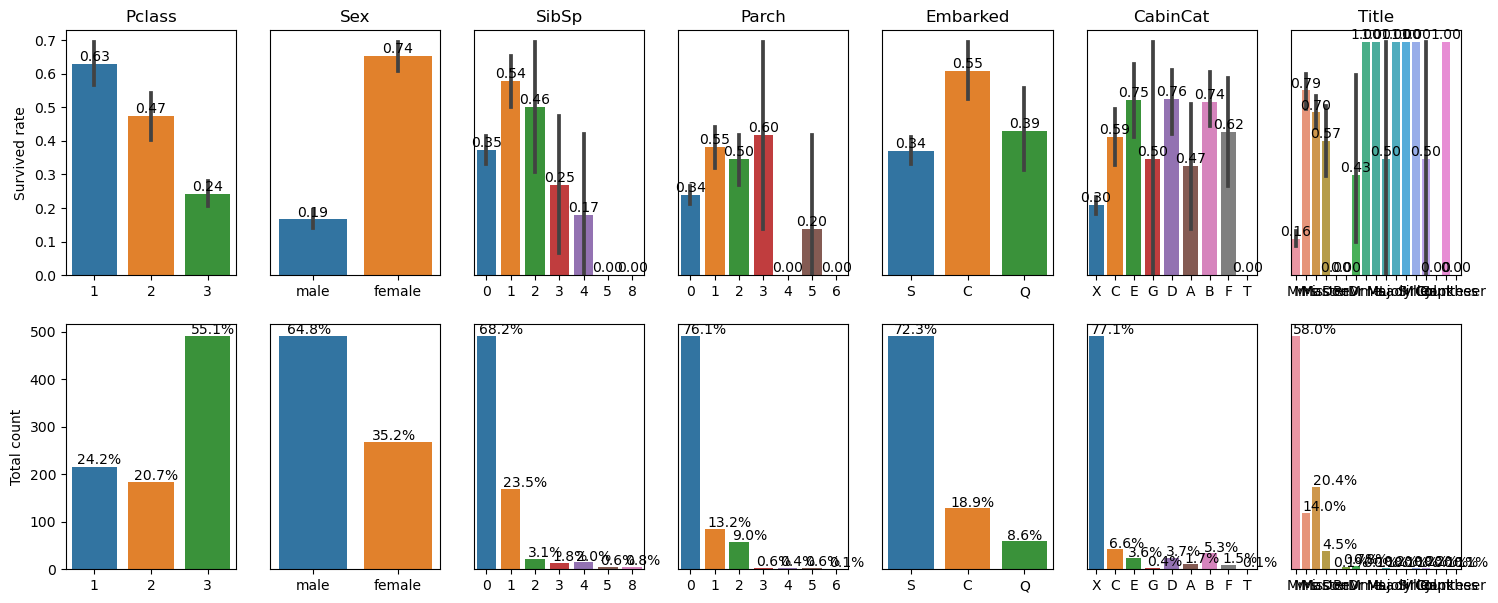

In [18]:
fig, axes = plt.subplots(2, 7, figsize=(18, 7), sharex=False, sharey=False)
i=-1
for col in find_categorical_columns(train_data_eda):
    i += 1
    if i==0:
        continue
    plot_count_and_rate(train_data_eda, col, 'Survived', (axes[0,i-1], axes[1,i-1]), i!=1)

Same with text.

In [19]:
for col in find_categorical_columns(train_data_eda):
    categorical_analysis(train_data_eda, col)

,count,percentage
Survived,,
0,549,61.62%
1,342,38.38%


,count,percentage,Survived
Pclass,,,
1,216,24.24%,0.629630
2,184,20.65%,0.472826
3,491,55.11%,0.242363


,count,percentage,Survived
Sex,,,
female,314,35.24%,0.742038
male,577,64.76%,0.188908


,count,percentage,Survived
SibSp,,,
0,608,68.24%,0.345395
1,209,23.46%,0.535885
2,28,3.14%,0.464286
3,16,1.80%,0.250000
4,18,2.02%,0.166667
5,5,0.56%,0.000000
8,7,0.79%,0.000000


,count,percentage,Survived
Parch,,,
0,678,76.09%,0.343658
1,118,13.24%,0.550847
2,80,8.98%,0.500000
3,5,0.56%,0.600000
4,4,0.45%,0.000000
5,5,0.56%,0.200000
6,1,0.11%,0.000000


,count,percentage,Survived
Embarked,,,
C,168,18.90%,0.553571
Q,77,8.66%,0.389610
S,644,72.44%,0.336957


,count,percentage,Survived
CabinCat,,,
A,15,1.68%,0.466667
B,47,5.27%,0.744681
C,59,6.62%,0.593220
D,33,3.70%,0.757576
E,32,3.59%,0.750000
F,13,1.46%,0.615385
G,4,0.45%,0.500000
T,1,0.11%,0.000000
X,687,77.10%,0.299854


,count,percentage,Survived
Title,,,
Capt,1,0.11%,0.000000
Col,2,0.22%,0.500000
Countess,1,0.11%,1.000000
Don,1,0.11%,0.000000
Dr,7,0.79%,0.428571
Jonkheer,1,0.11%,0.000000
Lady,1,0.11%,1.000000
Major,2,0.22%,0.500000
Master,40,4.49%,0.575000


Analyze numeric attributes.

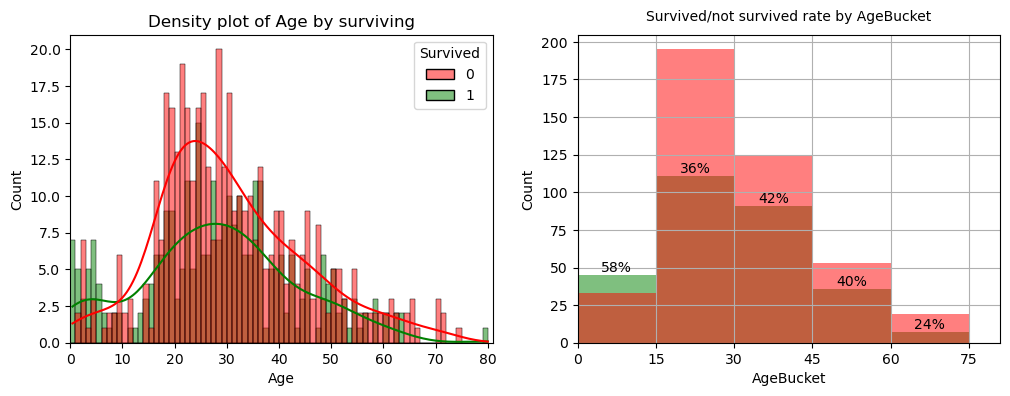

In [20]:
def plot_age_density(df):
    bins_range = range(int(min(df.Age)), int(max(df.Age)) + 1, 1)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=df, x='Age', kde=True, hue="Survived", bins=bins_range, 
                    palette = {1:'green', 0:'red'}, common_norm=False, ax=ax0)
    ax0.set_title("Density plot of Age by surviving")
    ax0.set_xlim(0, int(max(df.Age)) + 1)

    age_bucket_size = 15
    hist_bins = range(0,int(max(df.Age)) + 1,age_bucket_size)
    df["AgeBucket"] = df["Age"] // age_bucket_size * age_bucket_size
    age_buckets_means = df[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
    (df[df['Survived'] == 1]['AgeBucket']
         .hist(ax = ax1, bins = hist_bins, color = 'green', alpha = 0.5))
    (df[df['Survived'] == 0]['AgeBucket']
         .hist(ax = ax1, bins = hist_bins, color = 'red', alpha = 0.5))
    ax1.set_title("Survived/not survived rate by AgeBucket", fontsize=10, pad=10)
    ax1.set_xlabel('AgeBucket')
    ax1.set_ylabel('Count')
    ax1.set_xlim(0, int(max(df.Age)) + 1)
    plt.xticks(hist_bins)
    rects = ax1.patches
    for rect, label in zip(rects, age_buckets_means.values[:-1]):
        height = rect.get_height()
        label_pcnt = "{:.0%}".format(label[0])
        ax1.text(rect.get_x() + rect.get_width() / 2, height+0.01, label_pcnt,
                ha='center', va='bottom')
    plt.show()
plot_age_density(train_data_eda)

More accurate average age values.

In [21]:
train_data_eda[["Survived", "Age"]].groupby(['Survived']).mean()

,Age
Survived,
0,30.626179
1,28.343690


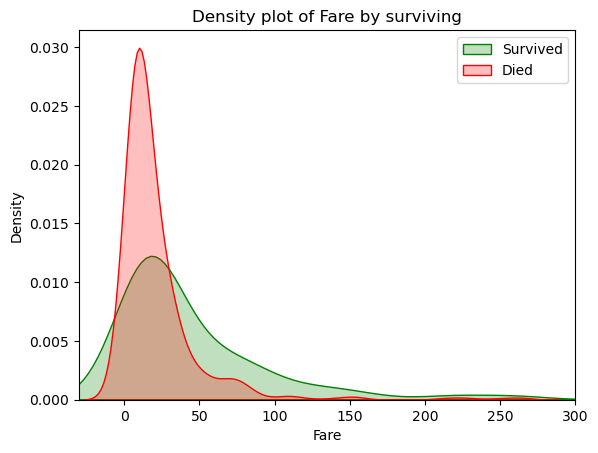

In [22]:
def plot_fare_density(df):
    ax = sns.kdeplot(data=df, x='Fare', hue="Survived", palette = {1:'green', 0:'red'}, 
                     fill=True, common_norm=False)
    plt.legend(['Survived', 'Died'])
    plt.title('Density plot of Fare by surviving')
    ax.set(xlabel='Fare')
    plt.xlim(-30,300)
    plt.show()
plot_fare_density(train_data_eda)

In [23]:
train_data_eda[["Survived", "Fare"]].groupby(['Survived']).mean()

,Fare
Survived,
0,22.117887
1,48.395408


We see that the survival rate for Pclass is relatively high. So let's see how other attributes are correlated with it. There are also missing values in the Age column, so let us see how it is distributed by Pclass and Sex.

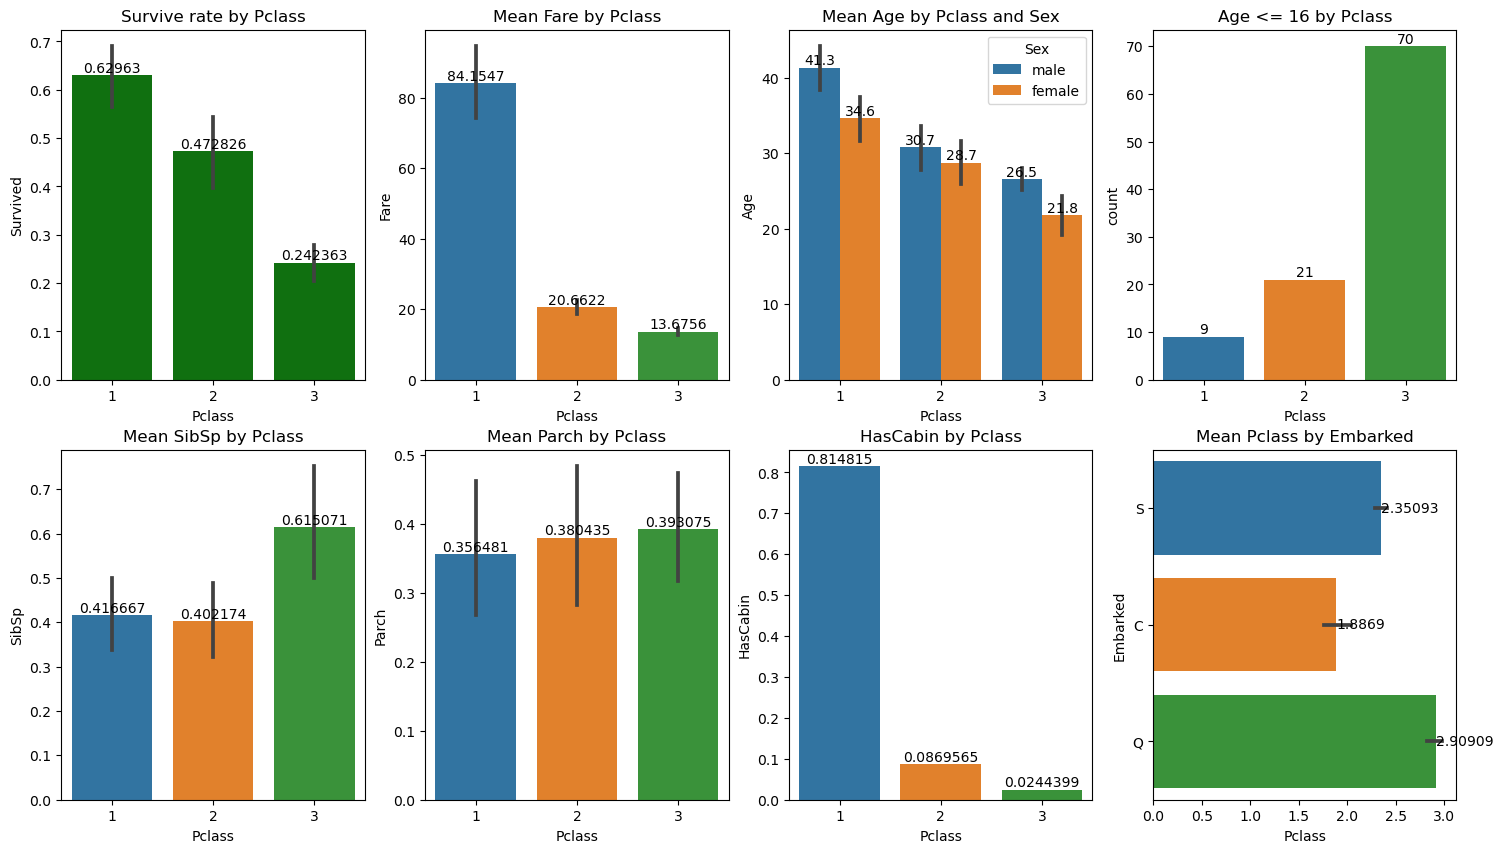

In [24]:
def plot_pclass_distributions(df):
    fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=False, sharey=False)
    sns.barplot(data=df, x='Pclass', y='Survived', color="green", ax=axes[0, 0])
    axes[0, 0].bar_label(axes[0, 0].containers[0])
    axes[0, 0].set_title("Survive rate by Pclass")

    sns.barplot(data=df, x='Pclass', y='Fare', ax=axes[0, 1])
    axes[0, 1].bar_label(axes[0, 1].containers[0])
    axes[0, 1].set_title("Mean Fare by Pclass")

    sns.barplot(data=df, x='Pclass', y='Age', hue="Sex", ax=axes[0, 2])
    for bars in axes[0, 2].containers:
            axes[0, 2].bar_label(bars, fmt='%.1f')
    axes[0, 2].set_title("Mean Age by Pclass and Sex")
    
    age_limit = 16
    sns.countplot(data=df.query(f'Age <= {age_limit}'), x='Pclass', ax=axes[0, 3])
    axes[0, 3].bar_label(axes[0, 3].containers[0])
    axes[0, 3].set_title(f"Age <= {age_limit} by Pclass")

    sns.barplot(data=df, x='Pclass', y='SibSp', ax=axes[1, 0])
    axes[1, 0].bar_label(axes[1, 0].containers[0])
    axes[1, 0].set_title("Mean SibSp by Pclass")

    sns.barplot(data=df, x='Pclass', y='Parch', ax=axes[1, 1])
    axes[1, 1].bar_label(axes[1, 1].containers[0])
    axes[1, 1].set_title("Mean Parch by Pclass")
    
    pclass_grouped_df = (df.groupby("Pclass")["Cabin"]
        .apply(lambda x: x.notna().sum()/x.shape[0]).reset_index())
    sns.barplot(data=pclass_grouped_df, x="Pclass", y="Cabin", ax=axes[1, 2])
    axes[1, 2].bar_label(axes[1, 2].containers[0])
    axes[1, 2].set(ylabel='HasCabin')
    axes[1, 2].set_title("HasCabin by Pclass")

    sns.barplot(data=df, x='Pclass', y='Embarked', ax=axes[1, 3])
    axes[1, 3].bar_label(axes[1, 3].containers[0])
    axes[1, 3].set_title("Mean Pclass by Embarked")
    
    plt.show()
    
plot_pclass_distributions(train_data_eda)

We see that empty cabin can be useful information. Mean age by Pclass and sex can also be used to fill in missing age values.

Add and modify some columns for correlation analysis.

In [25]:
le = LabelEncoder()
train_data_eda['Sex'] = le.fit_transform(train_data_eda['Sex'])
train_data_eda['Embarked'] = le.fit_transform(train_data_eda['Embarked'])
train_data_eda['CabinCat'] = le.fit_transform(train_data_eda['CabinCat'])
train_data_eda['Title'] = le.fit_transform(train_data_eda['Title'])

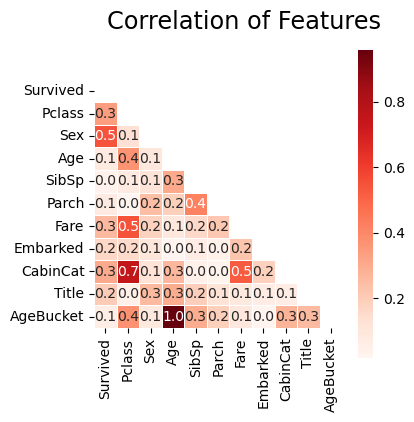

In [26]:
corr_matrix_abs = train_data_eda.corr().abs()
mask = np.triu(np.ones_like(corr_matrix_abs, dtype=bool))
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(corr_matrix_abs, mask=mask, annot=True,\
    linewidths=0.5, fmt=".1f", ax=ax, cmap="Reds", square=True)
plt.suptitle('Correlation of Features', size='xx-large')
plt.show()

Correlations between attributes and Survived.

In [27]:
(corr_matrix_abs['Survived']
     .sort_values(ascending=False)
     .to_frame())

,Survived
Survived,1.000000
Sex,0.543351
Pclass,0.338481
CabinCat,0.301116
Fare,0.257307
Title,0.201345
Embarked,0.163517
Parch,0.081629
Age,0.077221
AgeBucket,0.058848


### EDA Summary
1. The training dataset is relatively small, consisting of less than 1000 samples.
1. The number of attributes is also not large. It has 11 features, including five categorical and six numerical attributes, including the binary target (survived, died).
1. The following features have missing values: Age, Embarked, Fare and Cabin.
1. 1st class passengers had a higher chance of surviving, while 3rd class passengers mostly died.
1. Only 38% of passengers survived the disaster.
1. The more exclusive the class, the older the passengers.
1. Children and teenagers had a higher chance of survival, especially those in 1st class.
1. In terms of gender, women had a higher survival rate of 74% compared to men who had a survival rate of 19%.

Strategy for the feature ingeneering:
1. Pclass - leave as is.
1. Name - extract titles and encode them with OneHotEncoding.
1. Sex - encode with OneHotEncoding.
1. Age - impute missing values with k-Nearest Neighbors or median of individual groups.
1. Ticket - probably this attribute should be dropped.
1. Fare - impute with median.
1. Cabin - create a separate feature ('CabinCat') with categories for only the first letter and empty values.
1. Embarked - fill in the missing values with the most frequent one and encode with OneHotEncoding.

# Preprocessing Pipeline

Create Transformer which adds new features to the dataframe: Title, CabinCat.

In [28]:
class NewFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if not self.n_features_in_ == X.shape[1]:
            raise ValueError("Unexpected number of features.")
        check_is_fitted(self)
        Xc = X.copy()
        Xc["Title"] = Xc["Name"].str.extract(r" ([A-Za-z]+)\.")
        common_titles = ["Mr", "Miss", "Mrs", "Master"]
        unique_titles = np.setdiff1d(Xc["Title"], common_titles).tolist()
        Xc["Title"] = Xc["Title"].replace(unique_titles, "Other")
        Xc["CabinCat"] = Xc["Cabin"].apply(lambda x: "X" if pd.isna(x) else x[0])
        return Xc

    def get_feature_names_out(self, input_features=None):
        return np.r_[self.feature_names_in_, ["Title", "CabinCat"]]

Check how it works.

In [29]:
nfa = NewFeatureAdder()
train_data_nfa = nfa.fit_transform(train_data)
train_data_nfa.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinCat
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,X
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,X
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,X


Create preprocessing pipeline that prepares data for machine learning algorithms.

In [30]:
preprocessor = make_pipeline(
    NewFeatureAdder(),
    make_column_transformer(
        (StandardScaler(), ["Age"]),
        (make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            StandardScaler(),
        ), ['SibSp', 'Parch', "Pclass"]),
        (make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(),
        ), ['Fare']),
        (make_pipeline(
                SimpleImputer(strategy="most_frequent"),
                OneHotEncoder(sparse=False, handle_unknown='ignore'),
        ), ["Sex", "Embarked", "CabinCat", "Title"]),
        verbose_feature_names_out=False,
    ),
    # At this stage, only the `Age` attribute needs imputation.
    KNNImputer(n_neighbors=5)
)

set_config(display="diagram")
preprocessor

Pipeline(steps=[('newfeatureadder', NewFeatureAdder()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Age']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch', 'Pclass']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Fare']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex', 'Embarked',
                                                   'CabinCat', 'Title'])],
                                   verbose_feature_names_out=False)),
                ('knnimputer', KNNImputer())])

In [31]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', None),
])

Check how the pipeline works.

In [32]:
train_data_prep = train_data.copy()
train_data_prep_transformed = preprocessor.fit_transform(train_data_prep)

In [33]:
feature_names_out = preprocessor.get_feature_names_out()
pd.DataFrame(train_data_prep_transformed, columns=feature_names_out).head()

,Age,SibSp,Parch,Pclass,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinCat_A,CabinCat_B,CabinCat_C,CabinCat_D,CabinCat_E,CabinCat_F,CabinCat_G,CabinCat_T,CabinCat_X,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,-0.530377,0.432793,-0.473674,0.827377,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.571831,0.432793,-0.473674,-1.566107,0.786845,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.254825,-0.474545,-0.473674,0.827377,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.365167,0.432793,-0.473674,-1.566107,0.420730,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.365167,-0.474545,-0.473674,0.827377,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [34]:
feature_names_out

array(['Age', 'SibSp', 'Parch', 'Pclass', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinCat_A',
       'CabinCat_B', 'CabinCat_C', 'CabinCat_D', 'CabinCat_E',
       'CabinCat_F', 'CabinCat_G', 'CabinCat_T', 'CabinCat_X',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other'], dtype=object)

In [35]:
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Split data into train and validations sets.

In [36]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
X_full = train_data.drop("Survived", axis=1)
y_full = train_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, 
                                                    test_size=0.2, random_state=42,
                                                    stratify = y_full)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
print(f'Train shape. \t\tX: {X_train.shape}, y: {y_train.shape}',
    f'\nValidation shape. \tX: {X_val.shape}, y: {y_val.shape}')

Train shape. 		X: (712, 10), y: (712,) 
Validation shape. 	X: (179, 10), y: (179,)


In [38]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


# Model Training and Evaluation

Create reporting functions.

In [39]:
def plot_classification_report(clf_report, ax, vmin=0.8, vmax=1, classes_count=2):
    mask1 = np.zeros_like(clf_report, dtype=bool)
    mask1[classes_count:, :] = True
    mask2 = np.zeros_like(clf_report, dtype=bool)
    mask2[:classes_count, :] = True
    cmap_white = ListedColormap(['white'])
    sns.heatmap(clf_report, ax=ax, mask=mask1, annot=True, 
                cmap='viridis', fmt='.6f', cbar=False)
#                 cmap='viridis', fmt='.6f', vmin=vmin, vmax=vmax, cbar=False)
    sns.heatmap(clf_report, ax=ax, mask=mask2, annot=True, 
                cmap=cmap_white, fmt='.6f', cbar=False)
    ax.set_title("Classification report", fontsize=10, pad=10)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
def plot_confusion_matrix(conf_mx, ax, diag_toblack=True):
    norm_conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1, keepdims=True)
    if diag_toblack:
        np.fill_diagonal(norm_conf_mx, 0)
    sns.heatmap(norm_conf_mx, ax=ax, annot=False, cmap=plt.cm.gray, cbar=False)
    plt.title('Confusion matrix')
    thresh = norm_conf_mx.max() / 2
    for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
        plt.text(j+0.5, i+0.6, conf_mx[i, j],
            ha="center",
            va='baseline',
            color="white" if norm_conf_mx[i, j] < thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def display_evalreport(y_actual, y_predicted, set_name):
    display(Markdown(f'## <span style="color: black;">Evaluation on the {set_name}</span>'))
    accuracy = accuracy_score(y_actual, y_predicted)
    display(Markdown('Accuracy: {:.4f}%'.format(accuracy*100)))
    conf_mx = confusion_matrix(y_actual, y_predicted)
    classif_report_df = pd.DataFrame(classification_report(y_actual, y_predicted, output_dict=True)).iloc[:-1, :].T
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=False,
                               gridspec_kw={'width_ratios': [1, 2.2]}, dpi=100)
    plot_classification_report(classif_report_df, ax0)
    plot_confusion_matrix(conf_mx, ax1, False)
    fig.tight_layout()
    plt.show()

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
def plot_learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', splits=10):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, splits), scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

In [41]:
def display_cv_results(cv_results, sortby='mean_test_f1'):
    cv_results_df = pd.DataFrame(cv_results)
    cv_results_df['model'] = (cv_results_df['params']
                               .astype('str')
                               .str.findall('(?<=\'model\'. )\w+(?=\()')
                               .apply(', '.join))
    mean_columns = cv_results_df.filter(regex='^mean_test').columns.to_list()
    filtered_columns = np.concatenate((['model'], mean_columns))
    display(
        cv_results_df
            .sort_values(by=[sortby], ascending=False)
            .groupby('model')
            .first()
            .reindex(columns=filtered_columns)
            .loc[:, mean_columns]
            .sort_values(by=[sortby], ascending=False)
            .style
            .background_gradient(cmap='viridis'))

### Estimate different models

In [42]:
precision_scorer = make_scorer(precision_score, zero_division=0)
custom_scoring = {"accuracy": "accuracy", "precision": precision_scorer, "recall": "recall", "f1": "f1"}
params = [
    {'model': [
        SGDClassifier(),
        LogisticRegression(),
        SVC(),
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        xgb.XGBClassifier(),
        GaussianNB(),
        GradientBoostingClassifier()
    ]}]
grid_search = GridSearchCV(full_pipeline, params, cv=6, 
                           scoring=custom_scoring, n_jobs=-1, 
                           verbose=1, refit=False)
grid_search.fit(X_train, y_train)
(pd.DataFrame(grid_search.cv_results_)
    .sort_values(by=['rank_test_accuracy'], ascending=True).head())

Fitting 6 folds for each of 9 candidates, totalling 54 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split5_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,split5_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,mean_test_f1,std_test_f1,rank_test_f1
1,0.081808,0.008687,0.028432,0.001910,LogisticRegression(),{'model': LogisticRegression()},0.773109,0.840336,0.831933,0.848739,0.847458,0.813559,0.825856,0.026364,1,0.704545,0.760870,0.815789,0.813953,0.808511,0.800000,0.783945,0.040026,4,0.688889,0.813953,0.704545,0.777778,0.808511,0.734694,0.754728,0.048624,2,0.696629,0.786517,0.756098,0.795455,0.808511,0.765957,0.768194,0.036463,1
2,0.082624,0.003449,0.032428,0.000663,SVC(),{'model': SVC()},0.789916,0.831933,0.840336,0.857143,0.813559,0.805085,0.822995,0.022549,2,0.763158,0.767442,0.903226,0.833333,0.790698,0.825000,0.813809,0.047874,1,0.644444,0.767442,0.636364,0.777778,0.723404,0.673469,0.703817,0.056122,6,0.698795,0.767442,0.746667,0.804598,0.755556,0.741573,0.752438,0.031582,2
8,0.217932,0.023134,0.026432,0.005044,GradientBoostingClassifier(),{'model': GradientBoostingClassifier()},0.789916,0.831933,0.798319,0.882353,0.796610,0.805085,0.817369,0.031972,3,0.750000,0.810811,0.794118,0.878049,0.767442,0.809524,0.801657,0.040574,2,0.666667,0.697674,0.613636,0.800000,0.702128,0.693878,0.695664,0.055534,8,0.705882,0.750000,0.692308,0.837209,0.733333,0.747253,0.744331,0.046499,5
5,0.051613,0.003922,0.035032,0.000606,KNeighborsClassifier(),{'model': KNeighborsClassifier()},0.806723,0.840336,0.798319,0.848739,0.796610,0.805085,0.815969,0.020647,4,0.805556,0.785714,0.794118,0.829268,0.767442,0.782609,0.794118,0.019498,3,0.644444,0.767442,0.613636,0.755556,0.702128,0.734694,0.702983,0.056767,7,0.716049,0.776471,0.692308,0.790698,0.733333,0.757895,0.744459,0.034142,4
6,0.754329,0.031083,0.033962,0.000808,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.798319,0.789916,0.806723,0.848739,0.822034,0.796610,0.810390,0.019893,5,0.744186,0.714286,0.838710,0.800000,0.782609,0.777778,0.776261,0.039530,5,0.711111,0.697674,0.590909,0.800000,0.765957,0.714286,0.713323,0.065216,5,0.727273,0.705882,0.693333,0.800000,0.774194,0.744681,0.740894,0.037171,6


In [43]:
display_cv_results(grid_search.cv_results_)

,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
model,,,,
LogisticRegression,0.825856,0.783945,0.754728,0.768194
SVC,0.822995,0.813809,0.703817,0.752438
GaussianNB,0.786533,0.679491,0.841709,0.751246
KNeighborsClassifier,0.815969,0.794118,0.702983,0.744459
GradientBoostingClassifier,0.817369,0.801657,0.695664,0.744331
XGBClassifier,0.810390,0.776261,0.713323,0.740894
RandomForestClassifier,0.809037,0.766383,0.720344,0.739949
DecisionTreeClassifier,0.779412,0.711649,0.728114,0.716829
SGDClassifier,0.772492,0.734539,0.663836,0.688582


### Tuning Best Models

In [44]:
params_tune = [
    {
        'model': [SVC()],
        'model__kernel': ['rbf'],
        'model__C': np.arange(1, 15, 1),
        'model__gamma': np.arange(0.05, 0.65, 0.05)[:-1]
    }, 
    {
        'model': [LogisticRegression()],
        'model__solver': ['liblinear'],
        'model__C': np.arange(0.5, 25, 5),
        'model__penalty': ['l1', 'l2'],
        'model__max_iter': [4000]
    },
    {
        'model': [LogisticRegression()],
        'model__solver': ['lbfgs'],
        'model__C': np.arange(0.5, 25, 5),
        'model__max_iter': [4000]
    },
]
grid_search_tuned = GridSearchCV(full_pipeline, params_tune, cv=6, n_jobs=-1,
                                 scoring='accuracy', refit=True, verbose=1)
grid_search_tuned.fit(X_train, y_train)
(pd.DataFrame(grid_search_tuned.cv_results_)
    .sort_values(by=['rank_test_score'], ascending=True).head())

Fitting 6 folds for each of 169 candidates, totalling 1014 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__gamma,param_model__kernel,param_model__max_iter,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
11,0.075706,0.008925,0.027850,0.000468,"SVC(C=2, gamma=0.05)",2,0.05,rbf,NaN,NaN,NaN,"{'model': SVC(C=2, gamma=0.05), 'model__C': 2,...",0.789916,0.865546,0.831933,0.857143,0.813559,0.838983,0.832847,0.025538,1
39,0.086539,0.008748,0.028979,0.000692,"SVC(C=2, gamma=0.05)",4,0.35,rbf,NaN,NaN,NaN,"{'model': SVC(C=2, gamma=0.05), 'model__C': 4,...",0.798319,0.823529,0.823529,0.865546,0.855932,0.813559,0.830069,0.023430,2
50,0.087207,0.007974,0.029601,0.001662,"SVC(C=2, gamma=0.05)",5,0.35,rbf,NaN,NaN,NaN,"{'model': SVC(C=2, gamma=0.05), 'model__C': 5,...",0.789916,0.823529,0.823529,0.873950,0.855932,0.813559,0.830069,0.027583,2
71,0.093887,0.013864,0.031174,0.005388,"SVC(C=2, gamma=0.05)",7,0.3,rbf,NaN,NaN,NaN,"{'model': SVC(C=2, gamma=0.05), 'model__C': 7,...",0.789916,0.823529,0.831933,0.865546,0.855932,0.813559,0.830069,0.025359,2
0,0.077323,0.011245,0.030055,0.002114,"SVC(C=2, gamma=0.05)",1,0.05,rbf,NaN,NaN,NaN,"{'model': SVC(C=2, gamma=0.05), 'model__C': 1,...",0.798319,0.857143,0.831933,0.848739,0.813559,0.830508,0.830034,0.019857,5


In [45]:
display_cv_results(grid_search_tuned.cv_results_, 'mean_test_score')

,mean_test_score
model,
SVC,0.832847
LogisticRegression,0.825856


In [46]:
grid_search_tuned.best_params_

{'model': SVC(C=2, gamma=0.05),
 'model__C': 2,
 'model__gamma': 0.05,
 'model__kernel': 'rbf'}

In [47]:
display(f"Best score: {grid_search_tuned.best_score_}")

'Best score: 0.8328466980012345'

## <span style="color: black;">Evaluation on the Validation Set (tuned estimator)</span>

Accuracy: 84.3575%

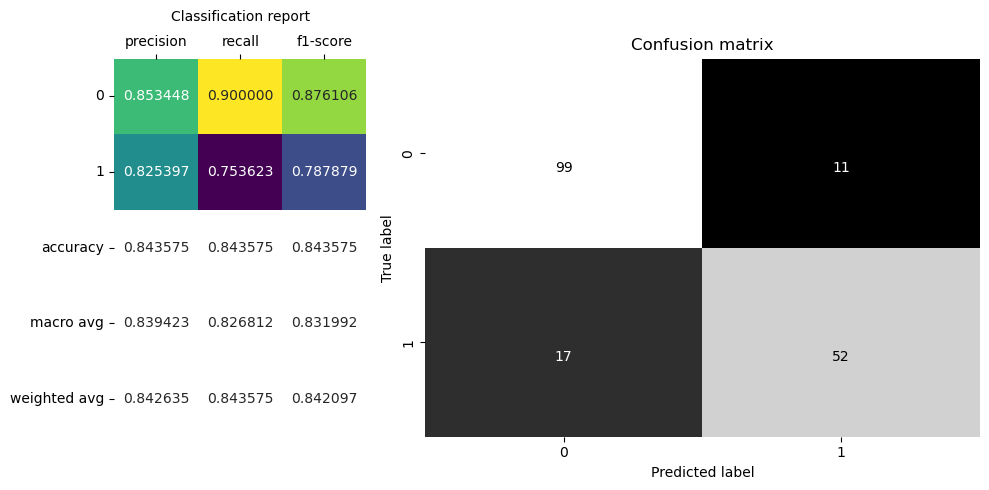

In [48]:
best_estimator = grid_search_tuned.best_estimator_
y_val_predicted_tuned = best_estimator.predict(X_val)
display_evalreport(y_val, y_val_predicted_tuned, "Validation Set (tuned estimator)")

Visualize loss with respect to hyperparameters

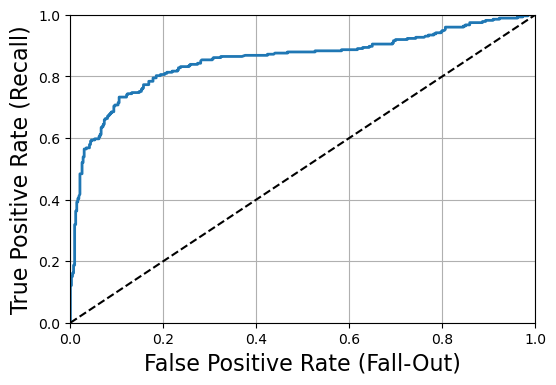

In [49]:
y_scores = cross_val_predict(best_estimator, X_train, y_train, cv=3,
                         method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plt.figure(figsize=(6, 4))
plot_roc_curve(fpr, tpr)
plt.show()

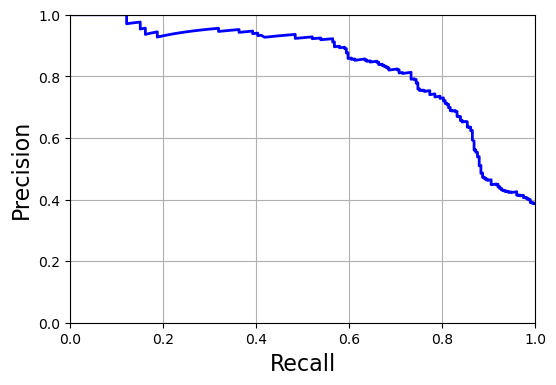

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(6, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

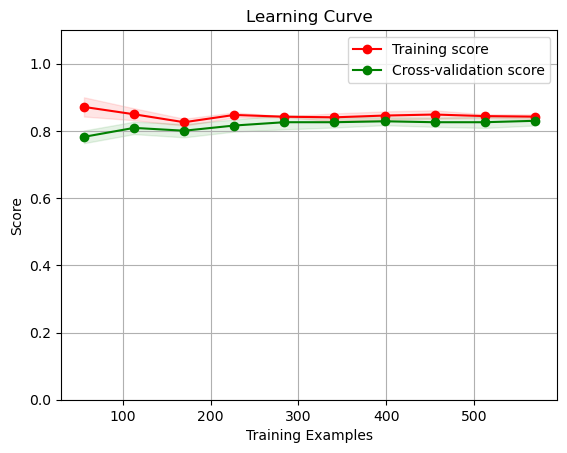

In [51]:
plot_learning_curve(best_estimator, X_train, y_train)

In [52]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Refit the best estimator on the full train dataset.

In [53]:
best_estimator.fit(X_full, y_full)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('newfeatureadder', NewFeatureAdder()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['Age']),
                                                                  ('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['SibSp',
                                                                    'Parch',
                                                                    'Pclass']),
                                                                  ('pipeline-2'...
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Fare']),
                                                                  ('pipeline-3',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['Sex',
                                                                    'Embarked',
                                                                    'CabinCat',
                                                                    'Title'])],
                                                    verbose_feature_names_out=False)),
                                 ('knnimputer', KNNImputer())])),
                ('model', SVC(C=2, gamma=0.05))])

## <span style="color: black;">Evaluation on the Full Training Set</span>

Accuracy: 83.8384%

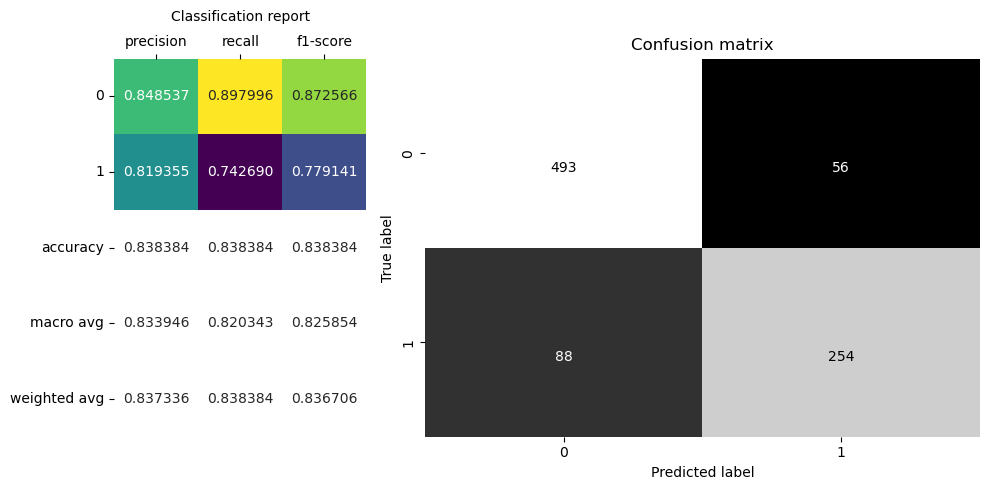

In [54]:
y_val_predicted_tuned = best_estimator.predict(X_full)
display_evalreport(train_data['Survived'], y_val_predicted_tuned, "Full Training Set")

# Submission

In [55]:
sumbission = pd.DataFrame(
    {
        "PassengerId": test_data.index,
        "Survived": best_estimator.predict(test_data),
    }
).set_index("PassengerId")

sumbission.to_csv("submission.csv")
sumbission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
